In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
import joblib
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
# Paths
train_dir = r"C:\Users\demen\Forensics_Research\DFFD_Dataset\Train"
val_dir = r"C:\Users\demen\Forensics_Research\DFFD_Dataset\Validation"
test_dir = r"C:\Users\demen\Forensics_Research\DFFD_Dataset\Test"

In [4]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(val_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['fake', 'real']
Valid_dir Subfolders:  ['fake', 'real']
Test_dir Subfolders:  ['fake', 'real']


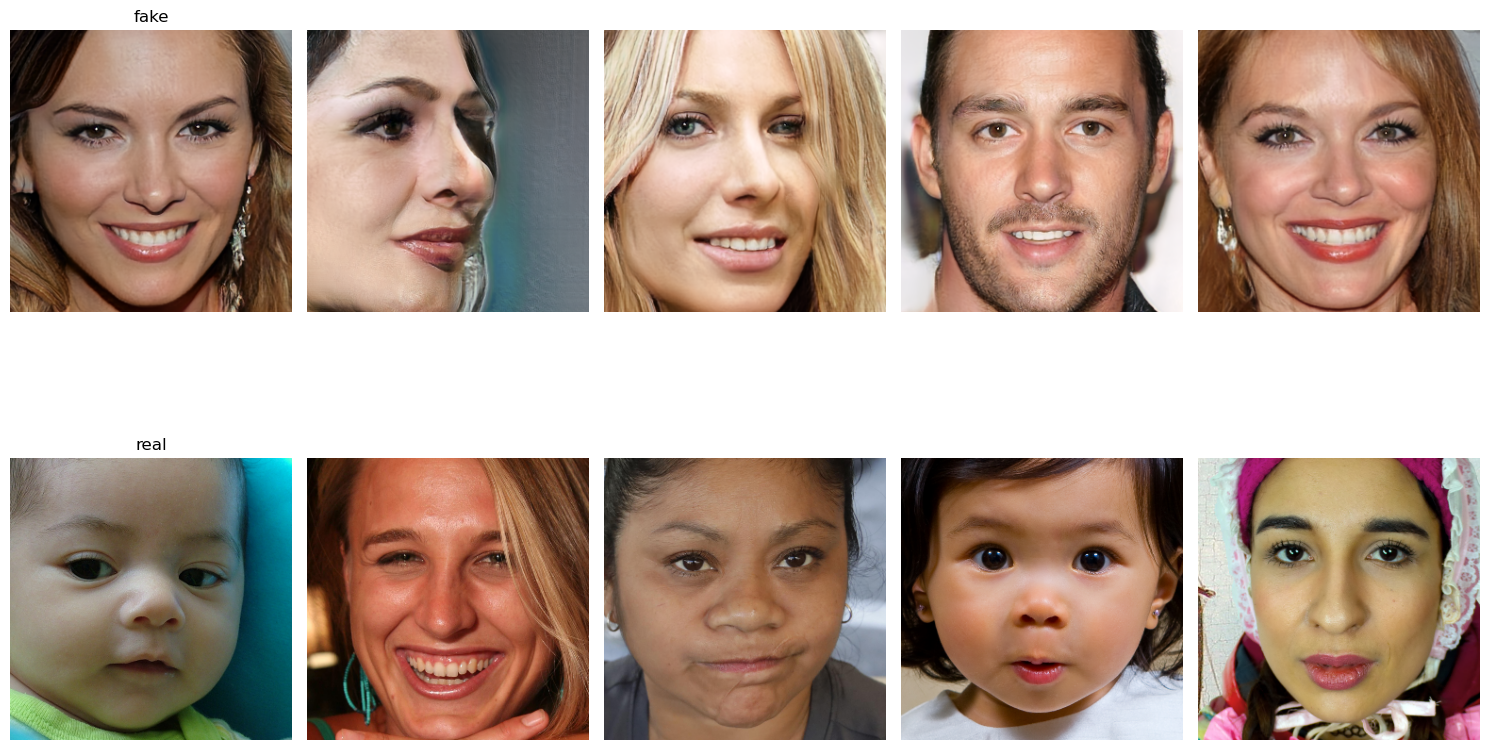

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class_names = ['fake', 'real']
num_images = 5

plt.figure(figsize=(15, 10))

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(train_dir, class_name)
    images = os.listdir(class_dir)
    plt.subplot(len(class_names), num_images, i * num_images + 1)
    plt.title(class_name)
    plt.axis('off')
    for j in range(num_images):
        img_path = os.path.join(class_dir, images[j])
        img = mpimg.imread(img_path)
        plt.subplot(len(class_names), num_images, i * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Image settings
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Generators
datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(
    train_dir, 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode='binary'
)
val_data = datagen.flow_from_directory(
    val_dir, 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode='binary'
)
test_data = datagen.flow_from_directory(
    test_dir, 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode='binary', 
    shuffle=False
)

Found 59956 images belonging to 2 classes.
Found 5997 images belonging to 2 classes.
Found 66860 images belonging to 2 classes.


In [7]:
# Function to create model
def create_model(base_model, name):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions, name=name)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [8]:
# Create and train each base model
def train_base_model(model_fn, base_model_name):
    print(f"\nTraining {base_model_name}...")
    base = model_fn(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base.layers:
        layer.trainable = False
    model = create_model(base, base_model_name)
    model.fit(train_data, validation_data=val_data, epochs=5)
    return model

In [9]:
# Train each base model
resnet_model = train_base_model(ResNet50, "ResNet50")


Training ResNet50...


D:\anacondapython\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 1118s 595ms/step - accuracy: 0.7465 - loss: 0.5775 - val_accuracy: 0.8334 - val_loss: 0.4505
Epoch 2/5
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 1106s 590ms/step - accuracy: 0.8347 - loss: 0.4573 - val_accuracy: 0.8334 - val_loss: 0.4491
Epoch 3/5
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 1110s 592ms/step - accuracy: 0.8338 - loss: 0.4523 - val_accuracy: 0.8334 - val_loss: 0.4480
Epoch 4/5
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 1110s 592ms/step - accuracy: 0.8343 - loss: 0.4491 - val_accuracy: 0.8334 - val_loss: 0.4472
Epoch 5/5
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 1108s 591ms/step - accuracy: 0.8347 - loss: 0.4474 - val_accuracy: 0.8334 - val_loss: 0.4465


In [10]:
vgg_model = train_base_model(VGG16, "VGG16")


Training VGG16...
Epoch 1/5
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 1957s 1s/step - accuracy: 0.7293 - loss: 0.5548 - val_accuracy: 0.8334 - val_loss: 0.4343
Epoch 2/5
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 1939s 1s/step - accuracy: 0.8338 - loss: 0.4425 - val_accuracy: 0.8334 - val_loss: 0.4220
Epoch 3/5
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 1981s 1s/step - accuracy: 0.8331 - loss: 0.4306 - val_accuracy: 0.8334 - val_loss: 0.4142
Epoch 4/5
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 1962s 1s/step - accuracy: 0.8349 - loss: 0.4187 - val_accuracy: 0.8336 - val_loss: 0.4088
Epoch 5/5
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 1961s 1s/step - accuracy: 0.8337 - loss: 0.4165 - val_accuracy: 0.8338 - val_loss: 0.4055


In [11]:
effnet_model = train_base_model(EfficientNetB0, "EfficientNetB0")


Training EfficientNetB0...
Epoch 1/5
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 589s 312ms/step - accuracy: 0.8303 - loss: 0.4681 - val_accuracy: 0.8334 - val_loss: 0.4505
Epoch 2/5
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 574s 306ms/step - accuracy: 0.8323 - loss: 0.4571 - val_accuracy: 0.8334 - val_loss: 0.4511
Epoch 3/5
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 574s 306ms/step - accuracy: 0.8322 - loss: 0.4555 - val_accuracy: 0.8334 - val_loss: 0.4506
Epoch 4/5
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 574s 306ms/step - accuracy: 0.8334 - loss: 0.4545 - val_accuracy: 0.8334 - val_loss: 0.4505
Epoch 5/5
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 576s 307ms/step - accuracy: 0.8336 - loss: 0.4527 - val_accuracy: 0.8334 - val_loss: 0.4504


In [12]:
# Extract features for stacking
def extract_features(model, data):
    feature_model = Model(model.input, model.layers[-2].output)  # before final dense
    features = feature_model.predict(data)
    return features

# Get features
X_train_resnet = extract_features(resnet_model, train_data)
X_train_vgg = extract_features(vgg_model, train_data)
X_train_eff = extract_features(effnet_model, train_data)

X_train_stack = np.concatenate([X_train_resnet, X_train_vgg, X_train_eff], axis=1)
y_train_stack = train_data.classes

X_test_resnet = extract_features(resnet_model, test_data)
X_test_vgg = extract_features(vgg_model, test_data)
X_test_eff = extract_features(effnet_model, test_data)
X_test_stack = np.concatenate([X_test_resnet, X_test_vgg, X_test_eff], axis=1)
y_test_stack = test_data.classes

1874/1874 ━━━━━━━━━━━━━━━━━━━━ 1007s 537ms/step
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 1761s 940ms/step
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 536s 286ms/step
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 1144s 547ms/step
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 1981s 948ms/step
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 646s 308ms/step


In [13]:
# Stack model with Logistic Regression meta-learner
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=3)
grid.fit(X_train_stack, y_train_stack)

D:\anacondapython\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anacondapython\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opt

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1, 10]})

In [14]:
print("Best Parameters:", grid.best_params_)

Best Parameters: {'C': 0.01}


In [15]:
# Save the model
joblib.dump(grid.best_estimator_, "stacked_model.pkl")

['stacked_model.pkl']

In [16]:
# Evaluate
y_pred = grid.predict(X_test_stack)
print("\nClassification Report:\n", classification_report(y_test_stack, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93     57860
           1       0.00      0.00      0.00      9000

    accuracy                           0.87     66860
   macro avg       0.43      0.50      0.46     66860
weighted avg       0.75      0.87      0.80     66860



D:\anacondapython\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anacondapython\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anacondapython\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


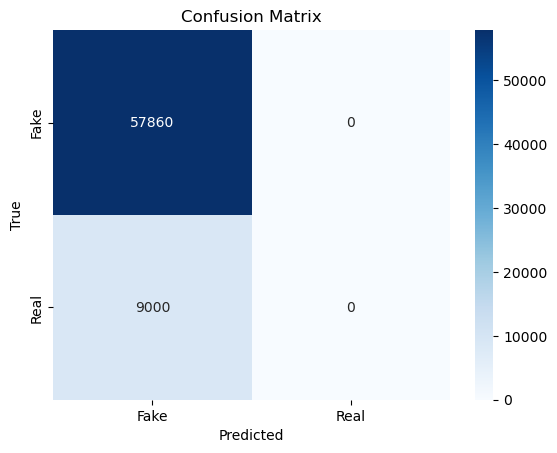

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test_stack, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [18]:
# Plotting training accuracy and loss from any one model
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()
    plt.show()

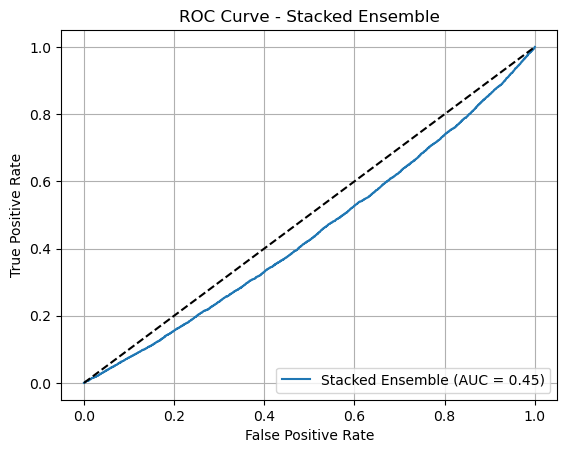

In [19]:
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_scores, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Stacked model ROC
y_scores = grid.best_estimator_.predict_proba(X_test_stack)[:, 1]
plot_roc(y_test_stack, y_scores, "Stacked Ensemble")